# Import


In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms


import lightning as L
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

import sys
import os
import numpy as np
import cv2
from datetime import datetime
from matplotlib import pyplot as plt

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "code"))
import dataset as D
from diff_augment import DiffAugment

config = {}

# /n03452741/n03452741_17620. jpeg' different image?

# Dataset


In [93]:
dataset = D.EEGDataset(eeg_dataset_file_name="eeg_5_95_std.pth")
root_path = "/Users/ms/cs/ML/NeuroImagen/"
dataset_path = os.path.join(root_path, "dataset")
images_dataset_path = os.path.join(dataset_path, "imageNet_images")

Epoch 0:   0%|          | 2/498 [1:49:52<454:09:40,  0.00it/s, v_num=0:19, g_loss_step=0.697, d_loss_step=1.600]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


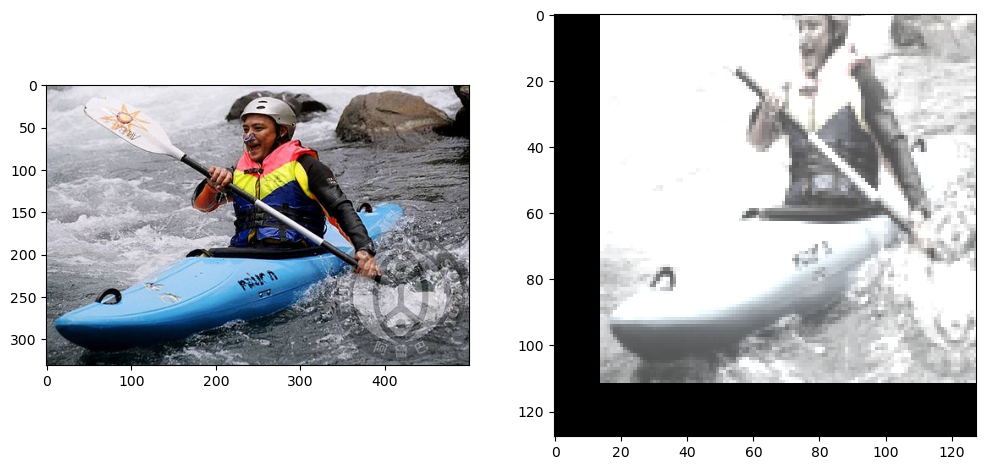

In [96]:
transform = transforms.Compose(
    [
        transforms.Resize((config["img-size"][1:3])),
        transforms.ToTensor(),
        # DiffAugment(policy="color,translation,cutout"),
        DiffAugment(policy=config["diffaug-policy"]),
    ]
)
eeg_img_dataset = D.EEGImageDataset(D.Splitter(dataset, split_name="train"), transform)
eeg_img_dataset_original = D.EEGImageDataset(D.Splitter(dataset, split_name="train"))

idx = 1
eeg, img = eeg_img_dataset[idx]
_, img_original = eeg_img_dataset_original[idx]

plt.figure(figsize=(12, 15))
plt.subplot(1, 2, 1)
plt.imshow(img_original)
plt.subplot(1, 2, 2)
plt.imshow(img.permute(1, 2, 0))
plt.show()
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [97]:
transform = transforms.Compose(
    [
        transforms.Resize((config["img-size"][1:3])),
        transforms.ToTensor(),
        # DiffAugment(policy="color,translation,cutout"),
        DiffAugment(policy=config["diffaug-policy"]),
    ]
)

loaders = {
    split: DataLoader(
        dataset=D.EEGImageDataset(D.Splitter(dataset, split_name=split), transform),
        batch_size=16,
        shuffle=True,
    )
    for split in ["train", "val", "test"]
}

# Model


In [98]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

config = {}

mps


In [99]:
class FeatureExtractor_ContrastiveLearning_NN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()

        # Triplet loss
        # def dist_fn(x1, x2):
        #     return torch.sum(torch.pow(torch.subtract(x1, x2), 2), dim=0)

        # self.loss_fn = nn.TripletMarginWithDistanceLoss(
        #     distance_function=dist_fn, margin=config["margin"]
        # )

        # model
        self.input_size = 128
        self.hidden_size = 128
        self.lstm_layers = 1
        self.out_size = 128

        self.lstm = nn.LSTM(
            self.input_size,
            self.hidden_size,
            num_layers=self.lstm_layers,
            batch_first=True,
        )
        self.output = nn.Sequential(
            nn.Linear(in_features=self.hidden_size, out_features=self.out_size),
            nn.ReLU(),
        )

    def forward(self, input):
        input = input.to(device)

        lstm_out, _ = self.lstm(input)
        res = self.output(lstm_out[:, -1, :])
        return res

In [175]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()

        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + 128, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(config["img-size"]))),
            nn.Tanh(),
        )

    def forward(self, noise, condition):
        gen_input = torch.cat((condition, noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *config["img-size"])
        return img

In [101]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(config["img-size"])) + 128, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, condition):
        d_input = torch.cat((img.view(img.size(0), -1), condition), -1)
        validity = self.model(d_input)
        return validity

In [177]:
class saliency_map_GAN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.automatic_optimization = False
        self.save_hyperparameters()

        # self.data_shape = (3, 32, 32)

        self.generator = Generator()
        self.discriminator = Discriminator()

        self.feature_extractor = (
            FeatureExtractor_ContrastiveLearning_NN.load_from_checkpoint(
                config["checkpoint"]
            )
        )
        self.feature_extractor.requires_grad_(False)
        self.loss_fn = self.adversarial_loss

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def forward(self, noise, condition):
        return self.generator(noise, condition)

    def training_step(self, batch, _):
        eegs, real_imgs = batch
        g_optim, d_optim = self.optimizers()

        batch_size = real_imgs.size(0)
        noise = torch.randn(batch_size, 100)
        noise = noise.to(device)
        real_imgs = real_imgs.to(device)

        eeg_features = self.feature_extractor(eegs)

        y_real = torch.ones([batch_size, 1], device=device, requires_grad=False)
        y_fake = torch.zeros([batch_size, 1], device=device, requires_grad=False)

        #####################
        # generator training
        #####################
        gen_imgs = self.generator(noise, eeg_features)
        y_hat = self.discriminator(gen_imgs, eeg_features)
        g_loss = self.loss_fn(y_hat, y_real)

        g_optim.zero_grad()
        self.manual_backward(g_loss)
        g_optim.step()

        #########################
        # discriminator training
        #########################
        y_hat = self.discriminator(real_imgs, eeg_features)
        d_loss_real = self.loss_fn(y_hat, y_real)

        gen_imgs = self.generator(noise, eeg_features)
        y_hat = self.discriminator(gen_imgs, eeg_features)
        d_loss_fake = self.loss_fn(y_hat, y_fake)

        d_loss = (d_loss_real + d_loss_fake) / 2

        d_optim.zero_grad()
        self.manual_backward(d_loss)
        d_optim.step()

        self.log_dict(
            {"g_loss": g_loss, "d_loss": d_loss}, prog_bar=True, on_epoch=True
        )

    # def validation_step(self, batch):
    #     return

    # def on_validation_epoch_end(self):
    #     print("HI")

    def test(self, eeg):
        noise = torch.randn(1, 100)
        eeg = eeg.unsqueeze(dim=0)
        condition = self.feature_extractor(eeg)

        noise = noise.to(device)
        condition = condition.to(device)

        return self.forward(noise, condition)

    def configure_optimizers(self):
        g_optim = optim.Adam(self.generator.parameters(), lr=1e-4)
        d_optim = optim.Adam(self.discriminator.parameters(), lr=1e-4)
        return [g_optim, d_optim], []

# Training


In [178]:
config = {
    "img-size": (3, 32, 32),
    "diffaug-policy": "color,translation",
    "checkpoint": "/Users/ms/cs/ML/NeuroImagen/lightning_logs/ContrastiveLossFeatureLearning/Adam_0.0001_LambdaLR_margin_1.5/weight-decay_0_lambda-factor_0.95/checkpoints/epoch=2-step=1491.ckpt",
}

In [179]:
model = saliency_map_GAN()
model.to(device)

logger = TensorBoardLogger(
    save_dir="/Users/ms/cs/ML/NeuroImagen/lightning_logs/SaliencyMapGAN/",
    name=f"test",
    version=datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
)
lr_monitor = LearningRateMonitor(logging_interval="epoch")

trainer = L.Trainer(max_epochs=200, callbacks=[lr_monitor], logger=logger)
trainer.fit(model, train_dataloaders=loaders["train"], val_dataloaders=loaders["val"])

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ms/anaconda3/envs/neuroimagen/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name              | Type                                    | Params
------------------------------------------------------------------------------
0 | generator         | Generator                               | 3.9 M 
1 | discriminator     | Discriminator                           | 1.8 M 
2 | feature_extractor | FeatureExtractor_ContrastiveLearning_NN | 148 K 
------------------------------------------------------------------------------
5.6 M     Trainable params
148 K     Non-trainable params
5.8 M     Total params
23.163    Total estimated model params size (MB)
/Users/ms/anaconda3/envs/neuroimagen/lib/python3.10/site-packa

Epoch 0:   0%|          | 0/498 [00:00<?, ?it/s] 

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (16x49280 and 3200x512)

# Testing


In [150]:
def test(model, eeg):
    model.eval()
    img = model.test(eeg)
    model.train()
    return img

In [ ]:
eeg, img = loaders["test"].dataset[20]

test(model, eeg)

# Test with checkpoint


In [106]:
CKPT_PATH = "/Users/ms/cs/ML/NeuroImagen/lightning_logs/SaliencyMapGAN/2023-12-07 21:11:09/checkpoints/epoch=2-step=2988.ckpt"

In [148]:
# try output one image from one random eeg. show generated image, original image
model = saliency_map_GAN.load_from_checkpoint(CKPT_PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 100])
torch.Size([1, 128])
torch.Size([1, 228])


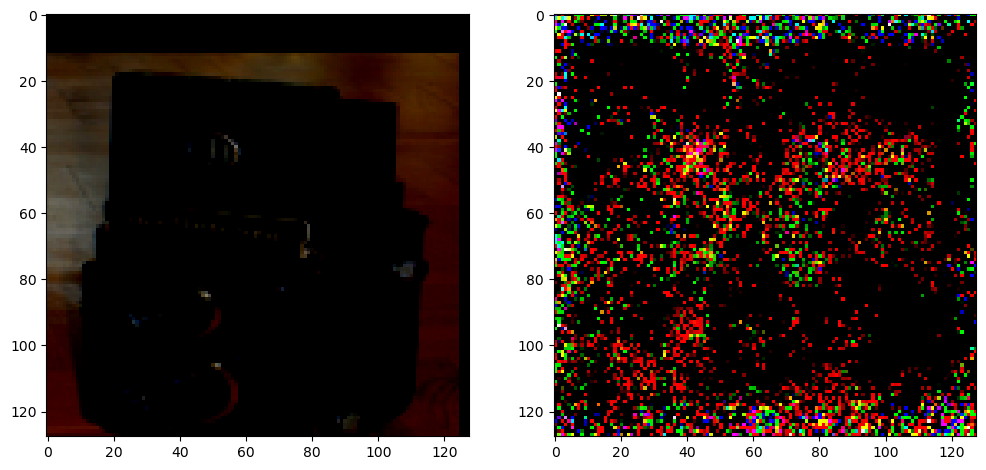

In [174]:
eeg, img = loaders["test"].dataset[20]

gen_img = test(model, eeg)
gen_img = gen_img.squeeze(dim=0).cpu().detach()


plt.figure(figsize=(12, 16))
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(gen_img.permute(1, 2, 0))
plt.show()